### Setup – Imports and Configuration (Adult)

- Imports all required libraries for the Adult experiments (data handling, plotting, preprocessing, models, metrics).
- Sets `RANDOM_STATE = 42` for reproducibility.
- Configures Seaborn/Matplotlib style and default figure size.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

print("Imports done, environment ready for Adult dataset")

Imports done, environment ready for Adult dataset


### Load and Clean Adult Dataset from Local CSV

- Reads `adult.csv` from `../data/` using the official UCI column names.
- Treats `"?"` as missing values and drops all rows containing any `NaN`.
- Splits data into:
  - `X_adult`: all feature columns.
  - `y_adult`: binary target (0 = `<=50K`, 1 = `>50K`).
- Prints dataset shapes, target class counts, and shows the first few feature rows.

In [26]:

# Column names as given in the UCI Adult dataset description
adult_columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

adult_path = "../data/adult.csv"

df_adult = pd.read_csv(
    adult_path,
    header=None,
    names=adult_columns,
    na_values="?",
    skipinitialspace=True,   # trims spaces after commas
)

print("Original shape:", df_adult.shape)

# Drop rows with any missing values
df_adult = df_adult.dropna()
print("Shape after dropping rows with missing values:", df_adult.shape)

# Separate features and target
X_adult = df_adult.drop(columns=["income"])
y_adult_raw = df_adult["income"]

# Encode target as 0/1: 1 = >50K (high income), 0 = <=50K
y_adult = (y_adult_raw == ">50K").astype(int)

print("\nTarget value counts (0 = <=50K, 1 = >50K):")
print(y_adult.value_counts())

print("\nFirst 5 rows of X_adult:")
display(X_adult.head())

Original shape: (32561, 15)
Shape after dropping rows with missing values: (30162, 15)

Target value counts (0 = <=50K, 1 = >50K):
income
0    22654
1     7508
Name: count, dtype: int64

First 5 rows of X_adult:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


### Train/Test Split (Adult)

- Splits `X_adult`, `y_adult` into:
  - `X_train_adult`, `y_train_adult` (80% train)
  - `X_test_adult`, `y_test_adult` (20% test)
- Uses `stratify=y_adult` to preserve the income class ratio in both sets.
- Prints shapes and class counts to verify the split.

In [27]:

X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(
    X_adult,
    y_adult,
    test_size=0.2,
    stratify=y_adult,
    random_state=RANDOM_STATE,
)

print("Train shape:", X_train_adult.shape)
print("Test shape:", X_test_adult.shape)

print("\nTrain target distribution:")
print(y_train_adult.value_counts())

print("\nTest target distribution:")
print(y_test_adult.value_counts())


Train shape: (24129, 14)
Test shape: (6033, 14)

Train target distribution:
income
0    18123
1     6006
Name: count, dtype: int64

Test target distribution:
income
0    4531
1    1502
Name: count, dtype: int64


### Identify Numeric vs Categorical Features (Adult)

- Manually lists the 6 numeric features (age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week).
- Treats all remaining columns in `X_train_adult` as categorical features.
- Prints both lists to confirm the feature-type split.

In [28]:

numeric_features_adult = [
    "age",
    "fnlwgt",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

categorical_features_adult = [
    col for col in X_train_adult.columns
    if col not in numeric_features_adult
]

print("Numeric features:", numeric_features_adult)
print("\nCategorical features:", categorical_features_adult)

Numeric features: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Categorical features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


### Preprocessing Pipeline (Adult)

- Builds a `ColumnTransformer` for mixed-type features:
  - Applies `StandardScaler` to numeric columns.
  - Applies `OneHotEncoder(handle_unknown="ignore")` to categorical columns.
- Stores this combined transformer as `preprocessor_adult` to reuse inside all Adult model pipelines.

In [29]:

numeric_transformer_adult = StandardScaler()
categorical_transformer_adult = OneHotEncoder(handle_unknown="ignore")

preprocessor_adult = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_adult, numeric_features_adult),
        ("cat", categorical_transformer_adult, categorical_features_adult),
    ]
)

print("Preprocessor for Adult ready")

Preprocessor for Adult ready


### Extra Import – FunctionTransformer

- Imports `FunctionTransformer` (used later to convert sparse matrices to dense arrays for Naive Bayes).

In [30]:
from sklearn.preprocessing import FunctionTransformer

### Define Models and Hyperparameter Grids (Adult)

- Creates a `dense_transformer` to convert sparse one-hot encoded features to dense arrays (needed for GaussianNB).
- Builds `models_adult` with 3 pipelines:
  - **Naive Bayes**: `preprocessor_adult` → `to_dense` → `GaussianNB`, grid over `var_smoothing`.
  - **Decision Tree**: `preprocessor_adult` → `DecisionTreeClassifier`, grid over `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`.
  - **MLP**: `preprocessor_adult` → `MLPClassifier` (with early stopping), grid over hidden sizes, activation, L2 `alpha`, and learning rate.
- Prints the list of defined model names.

In [31]:

# transformer to convert sparse matrix to dense for Naive Bayes
dense_transformer = FunctionTransformer(
    lambda x: x.toarray(),
    accept_sparse=True
)

models_adult = {}

# 1. Naive Bayes (GaussianNB) – preprocess -> to_dense -> NB
models_adult["Naive Bayes"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_adult),
            ("to_dense", dense_transformer),
            ("clf", GaussianNB()),
        ]
    ),
    "param_grid": {
        "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
    },
}

# 2. Decision Tree – preprocess -> tree
models_adult["Decision Tree"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_adult),
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ]
    ),
    "param_grid": {
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
    },
}

# 3. MLP – preprocess -> MLPClassifier
models_adult["MLP"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_adult),
            (
                "clf",
                MLPClassifier(
                    max_iter=200,
                    early_stopping=True,
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    ),
    "param_grid": {
        "clf__hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "clf__activation": ["relu", "tanh"],
        "clf__alpha": [1e-4, 1e-3],
        "clf__learning_rate_init": [0.001, 0.01],
    },
}

print("Models and grids for Adult defined")
print("Models:", list(models_adult.keys()))

Models and grids for Adult defined
Models: ['Naive Bayes', 'Decision Tree', 'MLP']


### Evaluation Helpers (Adult)

- `evaluate_on_test(...)`:
  - Uses a trained model to predict on `X_test`.
  - Computes accuracy, weighted precision, recall, F1-score, and a confusion matrix.
- `plot_confusion_matrix(...)`:
  - Plots the confusion matrix as a Seaborn heatmap with labelled axes and title.
- Shared by all three Adult models (NB, DT, MLP).

In [32]:

def evaluate_on_test(model, X_test, y_test):
    """Compute metrics and confusion matrix for a fitted model."""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    return {
        "accuracy": acc,
        "precision_weighted": prec,
        "recall_weighted": rec,
        "f1_weighted": f1,
        "confusion_matrix": cm,
        "labels": np.unique(y_test),
        "y_pred": y_pred,
    }

def plot_confusion_matrix(cm, labels, title="Confusion Matrix (Adult)"):
    """Plot a confusion matrix."""
    fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

print("Evaluation helpers ready")

Evaluation helpers ready


### Train & Evaluate All Models on Adult (5-fold CV)

- Creates a **Stratified 5-fold CV** splitter (`cv_adult`) to keep income class balance in each fold.
- For each model in `models_adult` (Naive Bayes, Decision Tree, MLP):
  - Runs `GridSearchCV` with the model’s pipeline and hyperparameter grid.
  - Fits on `X_train_adult`, `y_train_adult` and prints best hyperparameters + best CV accuracy.
  - Evaluates the best model on `X_test_adult` using `evaluate_on_test(...)`.
  - Prints test accuracy, weighted F1-score, full classification report, and plots the confusion matrix.
  - Stores all metrics in `results_adult_rows`.
- Finally builds and displays `results_adult`, a summary table of Adult dataset results for all three models.


Training model: Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.2s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.1s
[CV] END ...........

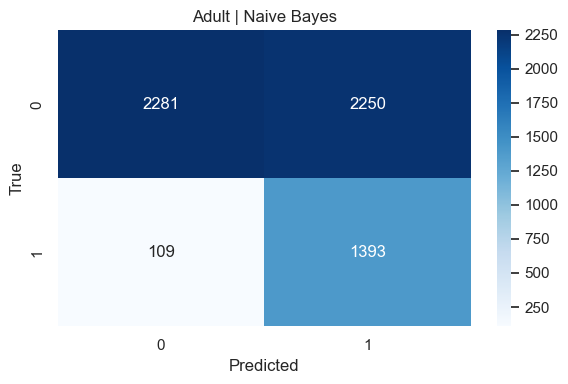


Training model: Decision Tree
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   0.3s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   0.3s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.3s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.3s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.3s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.3s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.3s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_

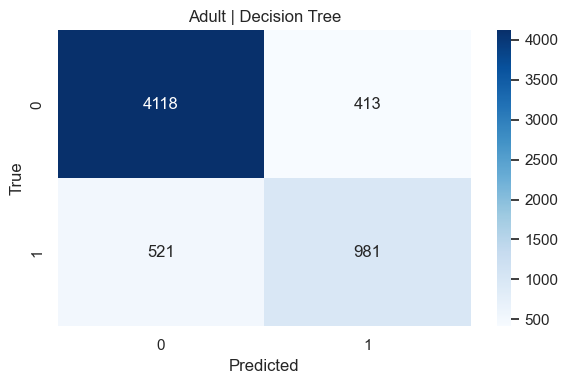


Training model: MLP
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.5s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.5s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.6s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.7s
[CV] 

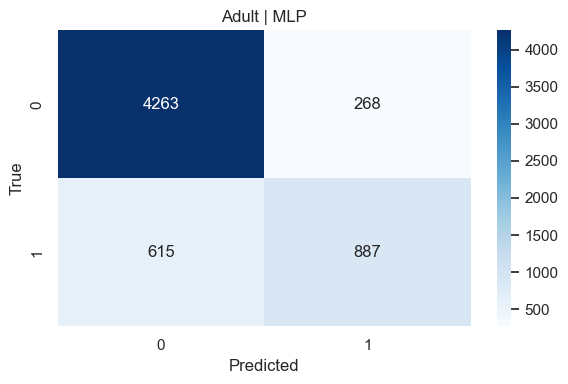


===== Summary table: Adult results =====


,model,best_params,cv_best_accuracy,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
0,Naive Bayes,{'clf__var_smoothing': 1e-07},0.589001,0.608984,0.629861,0.811982,0.608984
1,Decision Tree,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.851796,0.845185,0.843210,0.841892,0.845185
2,MLP,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",0.854366,0.853638,0.846780,0.847544,0.853638


In [33]:

cv_adult = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

results_adult_rows = []
best_models_adult = {}

for model_name, cfg in models_adult.items():
    print("\n========================================")
    print(f"Training model: {model_name}")
    print("========================================")

    grid = GridSearchCV(
        estimator=cfg["pipeline"],
        param_grid=cfg["param_grid"],
        cv=cv_adult,
        scoring="accuracy",
        n_jobs=-1,
        verbose=2,
    )

    # ---- TRAINING ----
    grid.fit(X_train_adult, y_train_adult)

    print(f"\nBest params for {model_name}:")
    print(grid.best_params_)
    print(f"Best CV accuracy for {model_name}: {grid.best_score_:.4f}")

    # store best model
    best_models_adult[model_name] = grid.best_estimator_

    # ---- TEST EVALUATION ----
    test_metrics = evaluate_on_test(grid.best_estimator_, X_test_adult, y_test_adult)

    print(f"\nTest accuracy for {model_name}: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (weighted) for {model_name}: {test_metrics['f1_weighted']:.4f}")
    print("\nClassification report:")
    print(
        classification_report(
            y_test_adult,
            test_metrics["y_pred"],
            zero_division=0
        )
    )

    # Confusion matrix (labels: 0 = <=50K, 1 = >50K)
    labels_numeric = test_metrics["labels"]
    plot_confusion_matrix(
        test_metrics["confusion_matrix"],
        labels_numeric,
        title=f"Adult | {model_name}",
    )

    # Results table row
    results_adult_rows.append(
        {
            "model": model_name,
            "best_params": grid.best_params_,
            "cv_best_accuracy": grid.best_score_,
            "test_accuracy": test_metrics["accuracy"],
            "test_f1_weighted": test_metrics["f1_weighted"],
            "test_precision_weighted": test_metrics["precision_weighted"],
            "test_recall_weighted": test_metrics["recall_weighted"],
        }
    )

# Final summary table
results_adult = pd.DataFrame(results_adult_rows)
print("\n===== Summary table: Adult results =====")
display(results_adult)

### Visualise MLP Training Behaviour (Adult)

- Defines `plot_mlp_curves_adult(...)` to inspect the best Adult MLP model:
  - Extracts `loss_curve_` (training loss per epoch) and `validation_scores_` (validation accuracy per epoch).
  - Plots:
    - Training loss vs. epochs.
    - Validation accuracy vs. epochs (if available).
- Helps diagnose convergence, stability, and possible overfitting of the Adult MLP.

In [34]:

def plot_mlp_curves_adult(best_mlp_pipeline, title_prefix="Adult"):
    """Plot loss_curve_ and validation_scores_ for the Adult MLP."""
    mlp_clf = best_mlp_pipeline.named_steps["clf"]

    loss_curve = getattr(mlp_clf, "loss_curve_", None)
    val_scores = getattr(mlp_clf, "validation_scores_", None)

    if loss_curve is None:
        print("No loss_curve_ found on MLP classifier.")
        return

    epochs = range(1, len(loss_curve) + 1)

    # Train loss
    plt.figure()
    plt.plot(epochs, loss_curve, label="Train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - MLP Training Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Validation accuracy (if available)
    if val_scores is not None:
        plt.figure()
        plt.plot(epochs, val_scores, label="Validation accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title_prefix} - MLP Validation Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("validation_scores_ not available (maybe early_stopping=False?).")

### Plot MLP Curves for Adult

- Calls `plot_mlp_curves_adult(...)` on the best Adult MLP pipeline.
- Displays the training loss and validation accuracy curves for the Adult dataset.

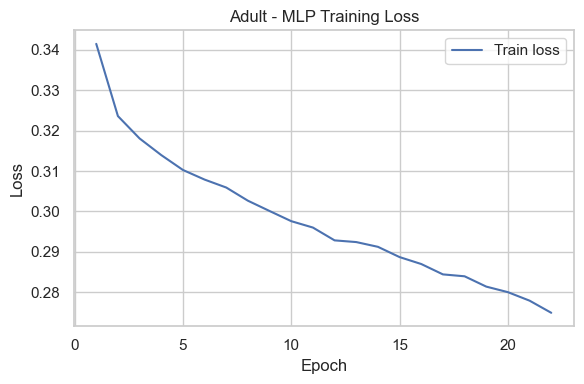

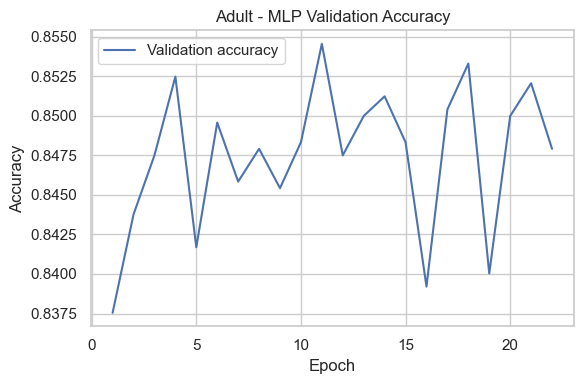

In [35]:
plot_mlp_curves_adult(best_models_adult["MLP"], title_prefix="Adult")

In [36]:

adult_features_llm = [
    "age",
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "hours-per-week",
]

# 1) Train + test DataFrames sirf in features + target ke saath
train_df_for_llm = X_train_adult[adult_features_llm].copy()
train_df_for_llm["target"] = y_train_adult.values   # 0 = <=50K, 1 = >50K

test_df_for_llm = X_test_adult[adult_features_llm].copy()
test_df_for_llm["target"] = y_test_adult.values

# 2) Few-shot examples: 3 low-income + 3 high-income
fewshot_low  = train_df_for_llm[train_df_for_llm["target"] == 0].sample(3, random_state=RANDOM_STATE)
fewshot_high = train_df_for_llm[train_df_for_llm["target"] == 1].sample(3, random_state=RANDOM_STATE)

fewshot_adult = (
    pd.concat([fewshot_low, fewshot_high], axis=0)
      .sample(frac=1, random_state=RANDOM_STATE)   # shuffle
      .reset_index(drop=True)
)

test_subset_adult_llm = (
    test_df_for_llm
    .sample(30, random_state=RANDOM_STATE)
    .reset_index(drop=True)
)

# 4) Label mapping
target_text_map_adult = {0: "<=50K", 1: ">50K"}

print(f"Number of features going to GPT: {len(adult_features_llm)}")

print("\n### FEW-SHOT TRAINING EXAMPLES (Adult)\n")
for i, row in fewshot_adult.iterrows():
    parts = [f"{feat}: {row[feat]}" for feat in adult_features_llm]
    features_str = ", ".join(parts)
    label_str = target_text_map_adult[row["target"]]
    print(f"Example {i+1}: {features_str} -> income: {label_str}")

print("\n### TEST EXAMPLES (Adult, GPT must predict income)\n")
for idx, row in test_subset_adult_llm.iterrows():
    parts = [f"{feat}: {row[feat]}" for feat in adult_features_llm]
    features_str = ", ".join(parts)
    print(f"Input {idx+1}: {features_str}")

Number of features going to GPT: 6

### FEW-SHOT TRAINING EXAMPLES (Adult)

Example 1: age: 48, workclass: Private, education: Some-college, marital-status: Divorced, occupation: Craft-repair, hours-per-week: 40 -> income: <=50K
Example 2: age: 21, workclass: Private, education: Assoc-voc, marital-status: Never-married, occupation: Adm-clerical, hours-per-week: 35 -> income: <=50K
Example 3: age: 56, workclass: Self-emp-not-inc, education: Some-college, marital-status: Married-civ-spouse, occupation: Exec-managerial, hours-per-week: 50 -> income: >50K
Example 4: age: 24, workclass: Private, education: 11th, marital-status: Never-married, occupation: Adm-clerical, hours-per-week: 40 -> income: <=50K
Example 5: age: 34, workclass: Local-gov, education: Some-college, marital-status: Married-civ-spouse, occupation: Protective-serv, hours-per-week: 40 -> income: >50K
Example 6: age: 34, workclass: Private, education: Bachelors, marital-status: Married-civ-spouse, occupation: Exec-managerial

In [37]:

import re

gpt_raw_adult = """
Input 1: >50K
Input 2: <=50K
Input 3: <=50K
Input 4: <=50K
Input 5: <=50K
Input 6: <=50K
Input 7: <=50K
Input 8: <=50K
Input 9: >50K
Input 10: <=50K
Input 11: <=50K
Input 12: <=50K
Input 13: <=50K
Input 14: >50K
Input 15: <=50K
Input 16: <=50K
Input 17: <=50K
Input 18: >50K
Input 19: <=50K
Input 20: >50K
Input 21: <=50K
Input 22: <=50K
Input 23: <=50K
Input 24: <=50K
Input 25: >50K
Input 26: <=50K
Input 27: <=50K
Input 28: >50K
Input 29: <=50K
Input 30: >50K
""".strip()

lines = gpt_raw_adult.splitlines()
gpt_preds = []

for line in lines:
    m = re.match(r"Input\s+(\d+):\s*(<=50K|>50K)", line.strip())
    if not m:
        print("[WARNING] Line skip ho rahi hai (format galat):", line)
        continue
    gpt_preds.append(m.group(2))


if len(gpt_preds) != 30:
    raise ValueError(f"Expected 30 predictions, but got {len(gpt_preds)}")


if "test_subset_adult_llm" not in globals():
    raise ValueError(
        "test_subset_adult_llm variable nahi mila. "
        "Pehle 'ADULT LLM STEP 1: Prepare few-shot + test examples (Adult)' waala cell dobara run karo."
    )

selected_features_adult_llm = [
    "age",
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "hours-per-week",
]

label_map_adult = {0: "<=50K", 1: ">50K"}

full_test_adult_for_merge = X_test_adult[selected_features_adult_llm].copy()
full_test_adult_for_merge["true_label"] = (
    y_test_adult.map(label_map_adult).values
)

true_labels = []
no_match_count = 0

for i in range(len(test_subset_adult_llm)):
    row = test_subset_adult_llm.iloc[i]

    mask = (full_test_adult_for_merge[selected_features_adult_llm] == row[selected_features_adult_llm]).all(axis=1)
    matched_rows = full_test_adult_for_merge[mask]

    if matched_rows.empty:
        print(f"[WARNING] No exact match found in X_test_adult for input #{i+1}")
        true_labels.append(None)
        no_match_count += 1
    else:
        true_labels.append(matched_rows.iloc[0]["true_label"])

true_labels = pd.Series(true_labels, name="true_label_str")
gpt_preds_series = pd.Series(gpt_preds, name="gpt_pred")

df_eval_adult = pd.DataFrame({
    "true_label": true_labels,
    "gpt_pred": gpt_preds_series,
})

print("\nFirst 5 true labels:")
print(df_eval_adult["true_label"].head())

print("\nFirst 5 GPT predictions:")
print(df_eval_adult["gpt_pred"].head())

print(f"\n[NOTE] {no_match_count} rows had no exact match; un rows ko evaluation se drop karenge.")

df_eval_adult_clean = df_eval_adult.dropna(subset=["true_label"]).copy()

print("\nEffective rows used for evaluation:", len(df_eval_adult_clean))

# 6) Metrics compute 
adult_llm_accuracy = accuracy_score(
    df_eval_adult_clean["true_label"],
    df_eval_adult_clean["gpt_pred"],
)

print(f"\nGPT Adult income prediction accuracy: {adult_llm_accuracy:.4f}")

print("\nClassification report (GPT vs ground truth):")
print(
    classification_report(
        df_eval_adult_clean["true_label"],
        df_eval_adult_clean["gpt_pred"],
        labels=["<=50K", ">50K"],
        zero_division=0,
    )
)


First 5 true labels:
0    <=50K
1     >50K
2    <=50K
3    <=50K
4    <=50K
Name: true_label, dtype: object

First 5 GPT predictions:
0     >50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: gpt_pred, dtype: object

[NOTE] 0 rows had no exact match; un rows ko evaluation se drop karenge.

Effective rows used for evaluation: 30

GPT Adult income prediction accuracy: 0.6667

Classification report (GPT vs ground truth):
              precision    recall  f1-score   support

       <=50K       0.73      0.80      0.76        20
        >50K       0.50      0.40      0.44        10

    accuracy                           0.67        30
   macro avg       0.61      0.60      0.60        30
weighted avg       0.65      0.67      0.66        30



### In-context learning on Adult dataset

For the Adult income dataset, we also tested GPT as an in-context learner using a few-shot prompt.  
We selected **6 interpretable features** – `age`, `workclass`, `education`, `marital-status`, `occupation`, and `hours-per-week` – and:

- Gave GPT **6 labelled examples** (few-shot training examples) with these 6 features and the income label (`<=50K` / `>50K`).
- Then asked it to predict income for **30 new test inputs** (same 6-feature format, shuffled subset of the true test set).
- Parsed GPT’s textual outputs and matched each input back to the corresponding row in our `X_test_adult` using these 6 features.

On these 30 test examples, GPT achieved:

- **Accuracy:** 0.667 (20/30 correct)
- **Class-wise performance:**
  - `<=50K`: precision ≈ 0.73, recall ≈ 0.80, F1 ≈ 0.76 (20 examples)
  - `>50K`: precision ≈ 0.50, recall ≈ 0.40, F1 ≈ 0.44 (10 examples)

Overall, GPT does reasonably well at this binary income prediction task using only a few context examples, but its performance is still below the tuned classical ML models on the same dataset (see Adult summary table above). It also shows a bias towards the majority class (`<=50K`), with lower recall on the minority high-income class (`>50K`).

In [38]:
# ==== HELPER: Add GPT (ICL) row + bar plots per dataset ====

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def add_llm_row_and_plot(results_df, dataset_name,
                          gpt_test_accuracy,
                          gpt_precision_weighted,
                          gpt_recall_weighted,
                          gpt_f1_weighted):
    """
    Takes the existing results_df (NB / DT / MLP),
    appends one row for GPT (ICL), and plots bar charts for
    test_accuracy and test_f1_weighted.
    """
    gpt_row = {
        "model": "GPT (ICL)",
        "best_params": "N/A",
        "cv_best_accuracy": np.nan,
        "test_accuracy": gpt_test_accuracy,
        "test_f1_weighted": gpt_f1_weighted,
        "test_precision_weighted": gpt_precision_weighted,
        "test_recall_weighted": gpt_recall_weighted,
    }

    results_with_llm = pd.concat(
        [results_df, pd.DataFrame([gpt_row])],
        ignore_index=True,
    )

    print(f"\n{dataset_name} – results including GPT (ICL):")
    display(results_with_llm[["model", "test_accuracy", "test_f1_weighted"]])

    for metric in ["test_accuracy", "test_f1_weighted"]:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=results_with_llm, x="model", y=metric)
        plt.ylim(0, 1.05)
        plt.title(f"{dataset_name} – {metric.replace('_',' ').title()} (NB / DT / MLP / GPT)")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

    return results_with_llm

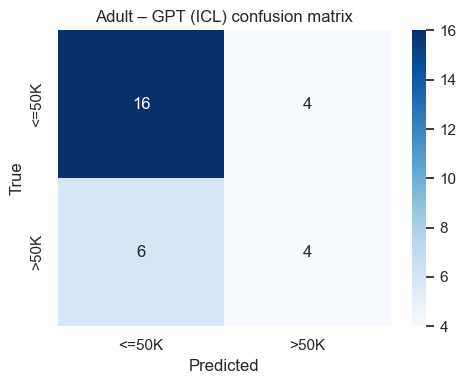

In [39]:
# ==== ADULT – GPT (ICL) confusion matrix ====

cm_adult_gpt = np.array([
    [16, 4],  # true <=50K
    [6,  4],  # true >50K
])

adult_labels = ["<=50K", ">50K"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm_adult_gpt, annot=True, fmt="d", cmap="Blues",
            xticklabels=adult_labels, yticklabels=adult_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Adult – GPT (ICL) confusion matrix")
plt.tight_layout()
plt.show()


Adult – results including GPT (ICL):


,model,test_accuracy,test_f1_weighted
0,Naive Bayes,0.608984,0.629861
1,Decision Tree,0.845185,0.843210
2,MLP,0.853638,0.846780
3,GPT (ICL),0.666700,0.660000


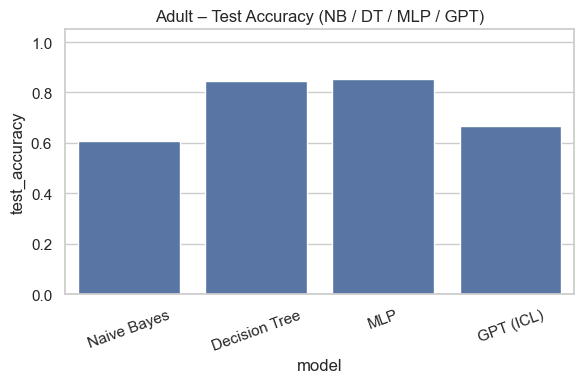

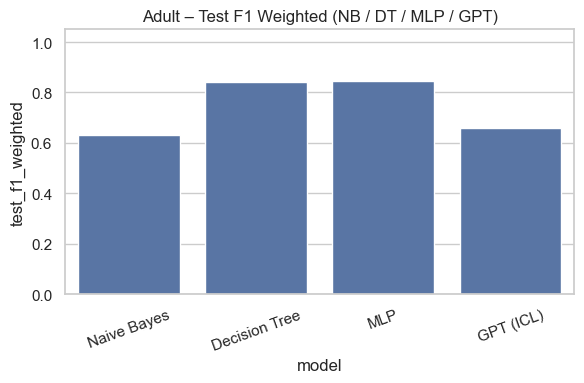

In [40]:

results_adult_with_llm = add_llm_row_and_plot(
    results_adult,
    dataset_name="Adult",
    gpt_test_accuracy=0.6667,   
    gpt_precision_weighted=0.65,
    gpt_recall_weighted=0.67,
    gpt_f1_weighted=0.66,
)